In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/KP/Google/Python/QD")
from sub import parameter, matrix, geometry
from scipy.sparse import csr_matrix, eye, diags
from scipy.sparse.linalg import eigs, spsolve


In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Define Geometry

In [3]:
dz = 2e-10
z = np.arange(0, 30e-9, dz)
nz = len(z)
eo = 8.85e-12
er = 3.6
c_array = np.ones(len(z))*er #* eo*er
V = 4
Vi = np.linspace(0, V, nz)
dE = 0.1
y = np.arange(-10, 0, dE) # Energy
kT = 0.0259
q = 1.6e-19

# Define Constant

In [4]:
EH = -7.3 # ev
EL = -4.2 
EF = -4.3

n = 4.1e18/1.42e-9*dz

# Define Inhomogeneous Poisson Matrix

In [5]:
z_boundary = 1 #Dirichlet : 0    Neumann : 1

if z_boundary == 0:
    poisson = diags(-np.append(c_array[1:], V) - np.append(c_array[0], c_array[:-1])) \
          + diags(c_array[1:], 1) + diags(c_array[:-1], -1)
elif z_boundary == 1:
    poisson = diags(-np.append(c_array[1:], c_array[-1]) - np.append(c_array[0], c_array[:-1])) \
          + diags(c_array[1:], 1) + diags(c_array[:-1], -1)
    poisson[-1,-2] *= 2
    #poisson[-1,-1] = 2*c_array[-1] 
    #poisson[-1,-2] = -c_array[-1] *2
poisson /= (dz)
poisson = csr_matrix(poisson)
#p = poisson.todense()

# Fermi Level

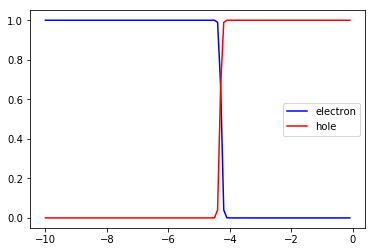

In [6]:
fH = 1/(1/2*np.exp(-(y-EF)/kT)+1)
fL = 1/(1/2*np.exp((y-EF)/kT)+1)
plt.plot(y, fL, 'b', label = 'electron')
plt.plot(y, fH, 'r', label = 'hole')
plt.legend()

# Density of States

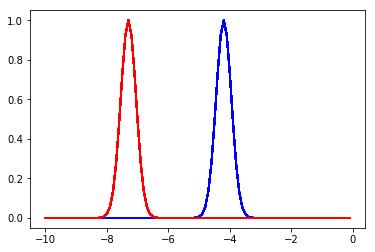

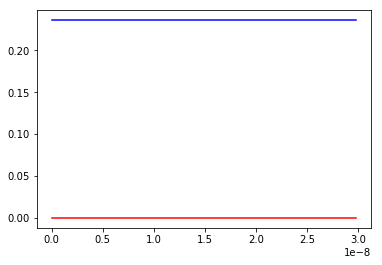

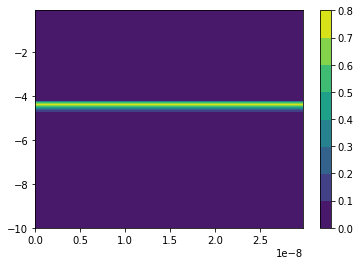

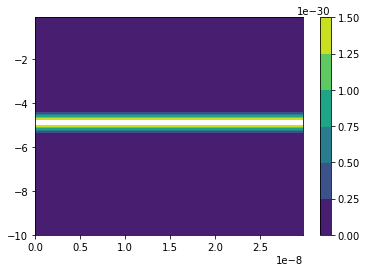

In [7]:
dosH = np.zeros((len(y), len(z)))
dosL = np.zeros((len(y), len(z)))
ne = np.zeros((len(y), len(z)))
nh = np.zeros((len(y), len(z)))

for i in range(len(z)):
    dosH[:,i] = gaussian(y, EH, 0.25)
    dosL[:,i] = gaussian(y, EL, 0.25)
for i in range(len(z)):
    ne[:,i] = dosL[:,i]*fL  # [/E /dz]
    nh[:,i] = dosH[:,i]*fH
plt.plot(y, dosL, 'b', label = 'DOS_E')
plt.plot(y, dosH, 'r', label = 'DOS_H')

neSum = np.sum(ne, axis = 0)*dE  # [/dz]
nhSum = np.sum(nh, axis = 0)*dE 
qden_old = q*n*(nhSum - neSum) # [C/m2/dz]
plt.figure()
plt.plot(z, neSum, 'b', label = 'electron')
plt.plot(z, nhSum, 'r', label = 'hole')
plt.figure()
plt.contourf(z,y, ne)
plt.colorbar()
plt.figure()
plt.contourf(z,y, nh)
plt.colorbar()


# Initial guess

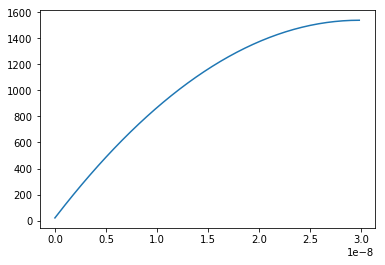

In [8]:
#qden_old /= 1000
#Vz = np.linalg.solve(poisson, -qden_old/eo)
Vz = spsolve(poisson, -qden_old/eo)
#fig, ax1 = plt.subplots(1,2)
plt.plot(z, -Vz)
#plt.ylim([-1.1,0])

# Iteration

0
1000
2000


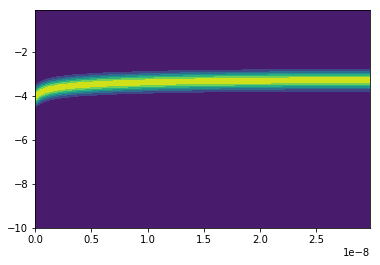

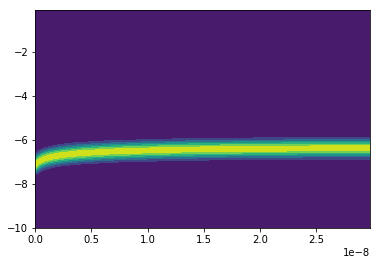

In [9]:
diff = 10
dosH = np.zeros((len(y), len(z)))
dosL = np.zeros((len(y), len(z)))
ne = np.zeros((len(y), len(z)))
nh = np.zeros((len(y), len(z)))

for k in range(10000):
    Vz = spsolve(poisson, -qden_old/eo)
    for i in range(len(z)):
        dosH[:,i] = gaussian(y, EH-Vz[i], 0.25)
        dosL[:,i] = gaussian(y, EL-Vz[i], 0.25)
    for i in range(len(z)):
        ne[:,i] = dosL[:,i]*fL
        nh[:,i] = dosH[:,i]*fH
    neSum = np.sum(ne, axis = 0)*dE
    nhSum = np.sum(nh, axis = 0)*dE
    qden_new = q*n*(nhSum - neSum)
    diff = np.sum(qden_old - qden_new)
    qden_old = (qden_old*99/100 + qden_new/100)
    if k % 1000 == 0:
        print k
    #qden_new *= 1000
    #plt.plot(z, -Vz)
#    plt.plot(y, dosL, 'r',  label = 'DOS_E')
    #plt.plot(y, dosL, 'g', label = 'DOS_H')
    if np.abs(diff) < 1e-6:
        break
    

    
plt.contourf(z, y, dosL)
plt.figure()
plt.contourf(z, y, dosH)

#plt.colorbar()
#plt.plot(z, -Vz)
#plt.figure()
#plt.plot(z, qden_old)

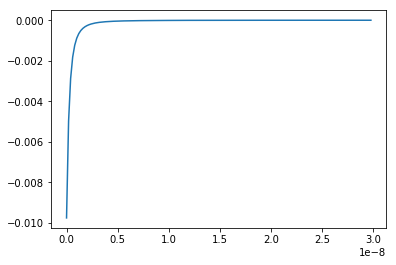

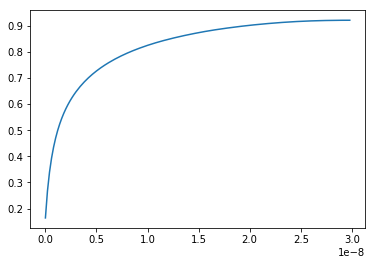

In [10]:
plt.plot(z, qden_old)
plt.figure()
plt.plot(z, -Vz)